- This notebook computes the somatic volume of cells and the 3D visualization of transcript distribution for selected cell types. 

In [69]:
import numpy as np
import pandas as pd
import glob
import scipy 
from tqdm import tqdm 
import anndata
import os

### 1. Cell volume Calculation based on somatic transcripts - restricted to neuronal cell types

In [91]:
import numpy as np
import pyvista as pv
import pandas as pd

In [ ]:
spatialModuleAnnotation = pd.read_csv(r'./../../processed_data/AP34_MERFISH/GroupLevelspatialModule_MatrixStriosome_included_cleaned_final.csv', index_col=0)
neuronal_celltypes = np.unique(spatialModuleAnnotation['Group_name'][spatialModuleAnnotation['Neighborhood_name'] != 'Nonneuron'])
neuronal_celltypes

array(['AMY-SLEA-BNST D1 GABA', 'AMY-SLEA-BNST GABA', 'BF SKOR1 Glut',
       'GPe MEIS2-SOX6 GABA', 'GPe SOX6-CTXND1 GABA',
       'GPe-NDB-SI LHX6-LHX8-GBX1 GABA', 'GPi Core', 'GPi Shell',
       'GPin-BF Cholinergic GABA', 'LAMP5-CXCL14 GABA', 'LAMP5-LHX6 GABA',
       'OB Dopa-GABA', 'OB FRMD7 GABA', 'OT D1 ICj', 'SN EBF2 GABA',
       'SN GATA3-PVALB GABA', 'SN SEMA5A GABA', 'SN SOX6 Dopa',
       'SN-VTR CALB1 Dopa', 'SN-VTR GAD2 Dopa',
       'SN-VTR-HTH GATA3-TCF7L2 GABA', 'STH PVALB-PITX2 Glut',
       'STR Cholinergic GABA', 'STR D1D2 Hybrid MSN',
       'STR FS PTHLH-PVALB GABA', 'STR LYPD6-RSPO2 GABA',
       'STR SST-ADARB2 GABA', 'STR SST-CHODL GABA', 'STR SST-RSPO2 GABA',
       'STR TAC3-PLPP4 GABA', 'STR-BF TAC3-PLPP4-LHX8 GABA',
       'STRd Cholinergic GABA', 'STRd D1 Matrix MSN',
       'STRd D1 Striosome MSN', 'STRd D2 Matrix MSN',
       'STRd D2 StrioMat Hybrid MSN', 'STRd D2 Striosome MSN',
       'STRv D1 MSN', 'STRv D1 NUDAP MSN', 'STRv D2 MSN', 'VIP GABA',
  

- copy the neuronal cell-types into a different folder, and manual check and remove artifacts.

In [ ]:
import glob
import os
import shutil
from tqdm import tqdm 
fls = glob.glob(r'./../../Lab/Raw_custom_MERFISH_Imaging_data/20250626_hBG_2724_GPie/NeuronImagesV2_BereketCopy' + os.sep + '*')
neuronal_celltypes_modified = list(map(lambda x: x.replace('-','_').replace(' ','_'),neuronal_celltypes))
for fl in tqdm(fls, desc = 'copying neuronal files'):
    cell_type = os.path.basename(fl).split('_icell')[0]
    if (cell_type in neuronal_celltypes) | (cell_type.replace('-','_').replace(' ','_') in neuronal_celltypes_modified):
        new_fl = fl.replace('NeuronImagesV2_BereketCopy','NeuronImagesV2_BereketCopyNeuronal')
        if not os.path.exists(os.path.dirname(new_fl)):
            os.makedirs(os.path.dirname(new_fl))
        shutil.copyfile(fl,new_fl)

copying neuronal files: 100%|██████████| 8180/8180 [01:38<00:00, 82.77it/s] 


In [93]:
neuronal_celltypes_modified = list(map(lambda x: x.replace('-','_').replace(' ','_'),neuronal_celltypes))

In [ ]:
import glob
import os
from scipy.spatial import ConvexHull
from tqdm import tqdm 
fls = glob.glob(r'./../../Raw_custom_MERFISH_Imaging_data/20250626_hBG_2724_GPie/NeuronImagesV2_BereketCopyNeuronal' + os.sep + '*_info.npz')
cell_volume = {}
cell_filename = {}
cell_sphericity = {}
def get_suface(pt_cloud):
    from scipy.spatial import cKDTree
    cloud = pv.PolyData(pt_cloud)
    # Estimate characteristic spacing
    k = 10
    tree = cKDTree(pt_cloud)
    # distances[:, i] is distance to ith neighbor (0 is self = 0)
    distances, _ = tree.query(pt_cloud, k=k+1)
    char = np.median(distances[:, -1])  # distance to the k-th neighbor

    alpha = 3.0 * char  # tune between ~2–4×


    tet = cloud.delaunay_3d(alpha=alpha)
    surf = tet.triangulate().clean()
    return surf

for fl in tqdm(fls, desc = 'computing geometry discriptor of cells'):
    cell_type = os.path.basename(fl).split('_icell')[0]
    cellfull_nm = os.path.basename(fl).split('.npz')[0]
    if cell_type not in neuronal_celltypes_modified: # skip if cell is not neuronal cell types
        continue 
    fl_val = np.load(fl,allow_pickle = True)
    soma_transcripts = fl_val['X'] # contains the transcript close to the Soma 
    Xnuc = fl_val['Xnuc'] # this is coordinate of the nucli 
    Xneigh = fl_val['Xneigh'] # contians all transcript
    
    # hull = ConvexHull(X)
    # vol_um3 = hull.volume
    # surf_area = hull.area 
    
    surf = get_suface(soma_transcripts)

    sphericity = ((np.pi**(1/3))*((6*surf.volume)**(2/3))/(surf.area + 1e-10))
    cell_volume[cell_type] = cell_volume.get(cell_type,[]) + [surf.volume]
    cell_sphericity = cell_volume.get(cell_type,[]) + [sphericity]

    # keep track of the cell full name 
    cell_filename[cell_type] = cell_filename.get(cell_type,[]) + [cellfull_nm]




computing geometry discriptor of cells: 100%|██████████| 2822/2822 [02:00<00:00, 23.35it/s]


- visualize the result as a box plot 


In [95]:
median_volm = {type_:np.median(cell_volume[type_]) for type_ in cell_volume}
volm_concat = np.hstack([cell_volume[type_] for type_ in cell_volume])
cell_type = np.hstack([[type_]*len(cell_volume[type_]) for type_ in cell_volume])
volm_df = pd.DataFrame(volm_concat,columns = ['cell_volume'])
volm_df['celltype'] = cell_type

# add the cell_filename 
cellFilename_concat = np.hstack([cell_filename[type_] for type_ in cell_filename])
volm_df['cellFilename'] = cellFilename_concat
# remove obvious artifactual cells 
artifactual_celltypes = ['Monocyte','Microglia','BAM','B_cells','SN_VTR_CALB1_Dopa','Ependymal','SMC','OB_Dopa_GABA','Oligo_OPALIN','AMY_SLEA_BNST_D1_GABA','SN_EBF2_GABA',
                         'SN_GATA3_PVALB_GABA','STH_PVALB_PITX2_Glut','SN_VTR_GAD2_Dopa','SN_SOX6_Dopa','SN_SEMA5A_GABA','OT_D1_ICj','SN_VTR_HTH_GATA3_TCF7L2_GABA']
# remove the data from artifactural cells 
artifacts = volm_df['celltype'].isin(artifactual_celltypes)
volm_df = volm_df[~artifacts]

# remove outlier samples within each celltype
volm_df_filtered = []
for celltype_ in np.unique(volm_df['celltype']):
    keep_celltype = volm_df['celltype'] == celltype_
    volm = volm_df[keep_celltype]['cell_volume']
    volm_pp2 = np.percentile(volm,30)
    volm_pp98 = np.percentile(volm,70)
    keep_samples = (volm > volm_pp2) & (volm < volm_pp98)
    volm_df_filtered += [volm_df[keep_celltype][keep_samples]]
volm_df_filtered = pd.concat(volm_df_filtered)

# # sorte the data frame from lowest to larget volume (median volume)

median_volm = {type_:np.median(volm_df_filtered[volm_df_filtered['celltype'] == type_]['cell_volume']) for type_ in np.unique(volm_df_filtered['celltype'])}
median_volm_val = list(median_volm.values())
median_volm_celltype = list(median_volm.keys())
sort_idx = np.argsort(median_volm_val)[::1]
sorted_celltype = np.array(median_volm_celltype)[sort_idx]
sorted_median_volm_val = np.array(median_volm_val)[sort_idx]
artifact = np.isin(sorted_celltype,artifactual_celltypes)
sorted_median_volm_val = sorted_median_volm_val[~artifact]
sorted_celltype = sorted_celltype[~artifact]

volm_df_filtered = pd.concat([volm_df_filtered[volm_df_filtered['celltype'] == type_] for type_ in sorted_celltype])
# # remove the data from artifactural cells 
artifacts = volm_df_filtered['celltype'].isin(artifactual_celltypes)
volm_df_filtered = volm_df_filtered[~artifacts]

In [96]:
med_vl = list(zip(sorted_median_volm_val,sorted_celltype))
med_vl

[(1590.312814690662, 'LAMP5_LHX6_GABA'),
 (1788.189981392383, 'LAMP5_CXCL14_GABA'),
 (1993.9456623461565, 'STR_LYPD6_RSPO2_GABA'),
 (2108.1462812810228, 'STR_SST_RSPO2_GABA'),
 (2313.9308340678876, 'STRd_D2_Matrix_MSN'),
 (2321.8760145628557, 'STR_D1D2_Hybrid_MSN'),
 (2351.665398368824, 'STR_SST_ADARB2_GABA'),
 (2365.225490165622, 'STRd_D1_Matrix_MSN'),
 (2491.911888105493, 'AMY_SLEA_BNST_GABA'),
 (2537.272918413926, 'STRd_D1_Striosome_MSN'),
 (2609.522528604672, 'STR_BF_TAC3_PLPP4_LHX8_GABA'),
 (2763.0290675175256, 'STRd_D2_StrioMat_Hybrid_MSN'),
 (3159.89026481122, 'STR_TAC3_PLPP4_GABA'),
 (3749.2266367802044, 'BF_SKOR1_Glut'),
 (3967.357054584206, 'STR_FS_PTHLH_PVALB_GABA'),
 (4269.243730757202, 'OB_FRMD7_GABA'),
 (4668.993988945492, 'GPe_MEIS2_SOX6_GABA'),
 (5154.794162651342, 'GPe_SOX6_CTXND1_GABA'),
 (5203.593313744664, 'GPi_Core'),
 (5490.238762196919, 'GPi_Shell'),
 (5796.103770779463, 'GPe_NDB_SI_LHX6_LHX8_GBX1_GABA'),
 (6190.266291923514, 'STR_SST_CHODL_GABA'),
 (7088.6256232

In [97]:
[v for v,k in med_vl if 'msn' in k.lower()],np.median([v for v,k in med_vl if 'msn' in k.lower()])

([2313.9308340678876,
  2321.8760145628557,
  2365.225490165622,
  2537.272918413926,
  2763.0290675175256],
 2365.225490165622)

In [98]:
volm_df_filtered

,cell_volume,celltype,cellFilename
2426,1722.482118,LAMP5_LHX6_GABA,LAMP5_LHX6_GABA_icell57_info
2431,1239.564972,LAMP5_LHX6_GABA,LAMP5_LHX6_GABA_icell20_info
2436,1782.831257,LAMP5_LHX6_GABA,LAMP5_LHX6_GABA_icell81_info
2437,1309.168283,LAMP5_LHX6_GABA,LAMP5_LHX6_GABA_icell68_info
2438,1351.243488,LAMP5_LHX6_GABA,LAMP5_LHX6_GABA_icell67_info
...,...,...,...
932,8833.632235,STRd_Cholinergic_GABA,STRd_Cholinergic_GABA_icell12_info
934,9524.667140,STRd_Cholinergic_GABA,STRd_Cholinergic_GABA_icell55_info
935,9131.904039,STRd_Cholinergic_GABA,STRd_Cholinergic_GABA_icell2_info
950,8588.921280,STRd_Cholinergic_GABA,STRd_Cholinergic_GABA_icell62_info


- get the dictionary for colormap of cell types

In [ ]:
cluster_map = np.load(r'./../../../cluster_cmap_final_updated_9172025.npy',allow_pickle=True).item()
cluster_map_ = {k.replace('-','_').replace(' ','_'):v for k,v in cluster_map.items()}


In [100]:
sorted_celltype

array(['LAMP5_LHX6_GABA', 'LAMP5_CXCL14_GABA', 'STR_LYPD6_RSPO2_GABA',
       'STR_SST_RSPO2_GABA', 'STRd_D2_Matrix_MSN', 'STR_D1D2_Hybrid_MSN',
       'STR_SST_ADARB2_GABA', 'STRd_D1_Matrix_MSN', 'AMY_SLEA_BNST_GABA',
       'STRd_D1_Striosome_MSN', 'STR_BF_TAC3_PLPP4_LHX8_GABA',
       'STRd_D2_StrioMat_Hybrid_MSN', 'STR_TAC3_PLPP4_GABA',
       'BF_SKOR1_Glut', 'STR_FS_PTHLH_PVALB_GABA', 'OB_FRMD7_GABA',
       'GPe_MEIS2_SOX6_GABA', 'GPe_SOX6_CTXND1_GABA', 'GPi_Core',
       'GPi_Shell', 'GPe_NDB_SI_LHX6_LHX8_GBX1_GABA',
       'STR_SST_CHODL_GABA', 'STR_Cholinergic_GABA',
       'GPin_BF_Cholinergic_GABA', 'STRd_Cholinergic_GABA'], dtype='<U30')

In [101]:
# mapping between the modified name and actual name of cells 
celltype_name_mapping = {nm.replace('-','_').replace(' ','_'):nm for nm in cluster_map}
volm_df_filtered['celltype_actual_name'] = volm_df_filtered['celltype'].replace(celltype_name_mapping)

In [ ]:
# replace the cell type name with short name 
import pandas as pd
Allen_short_name = pd.read_csv(r'./../Reference_snRNAseq_Allen/HMBA_BG_consensus_annotation_consensus_anno_pre_print.csv')
group = Allen_short_name['Group'].values
short_group_name = Allen_short_name['short_name_group'].values

short_name_mapper = dict(zip(group,short_group_name))
volm_df_filtered['celltype_actual_name_short'] = volm_df_filtered['celltype_actual_name'].replace(short_name_mapper)

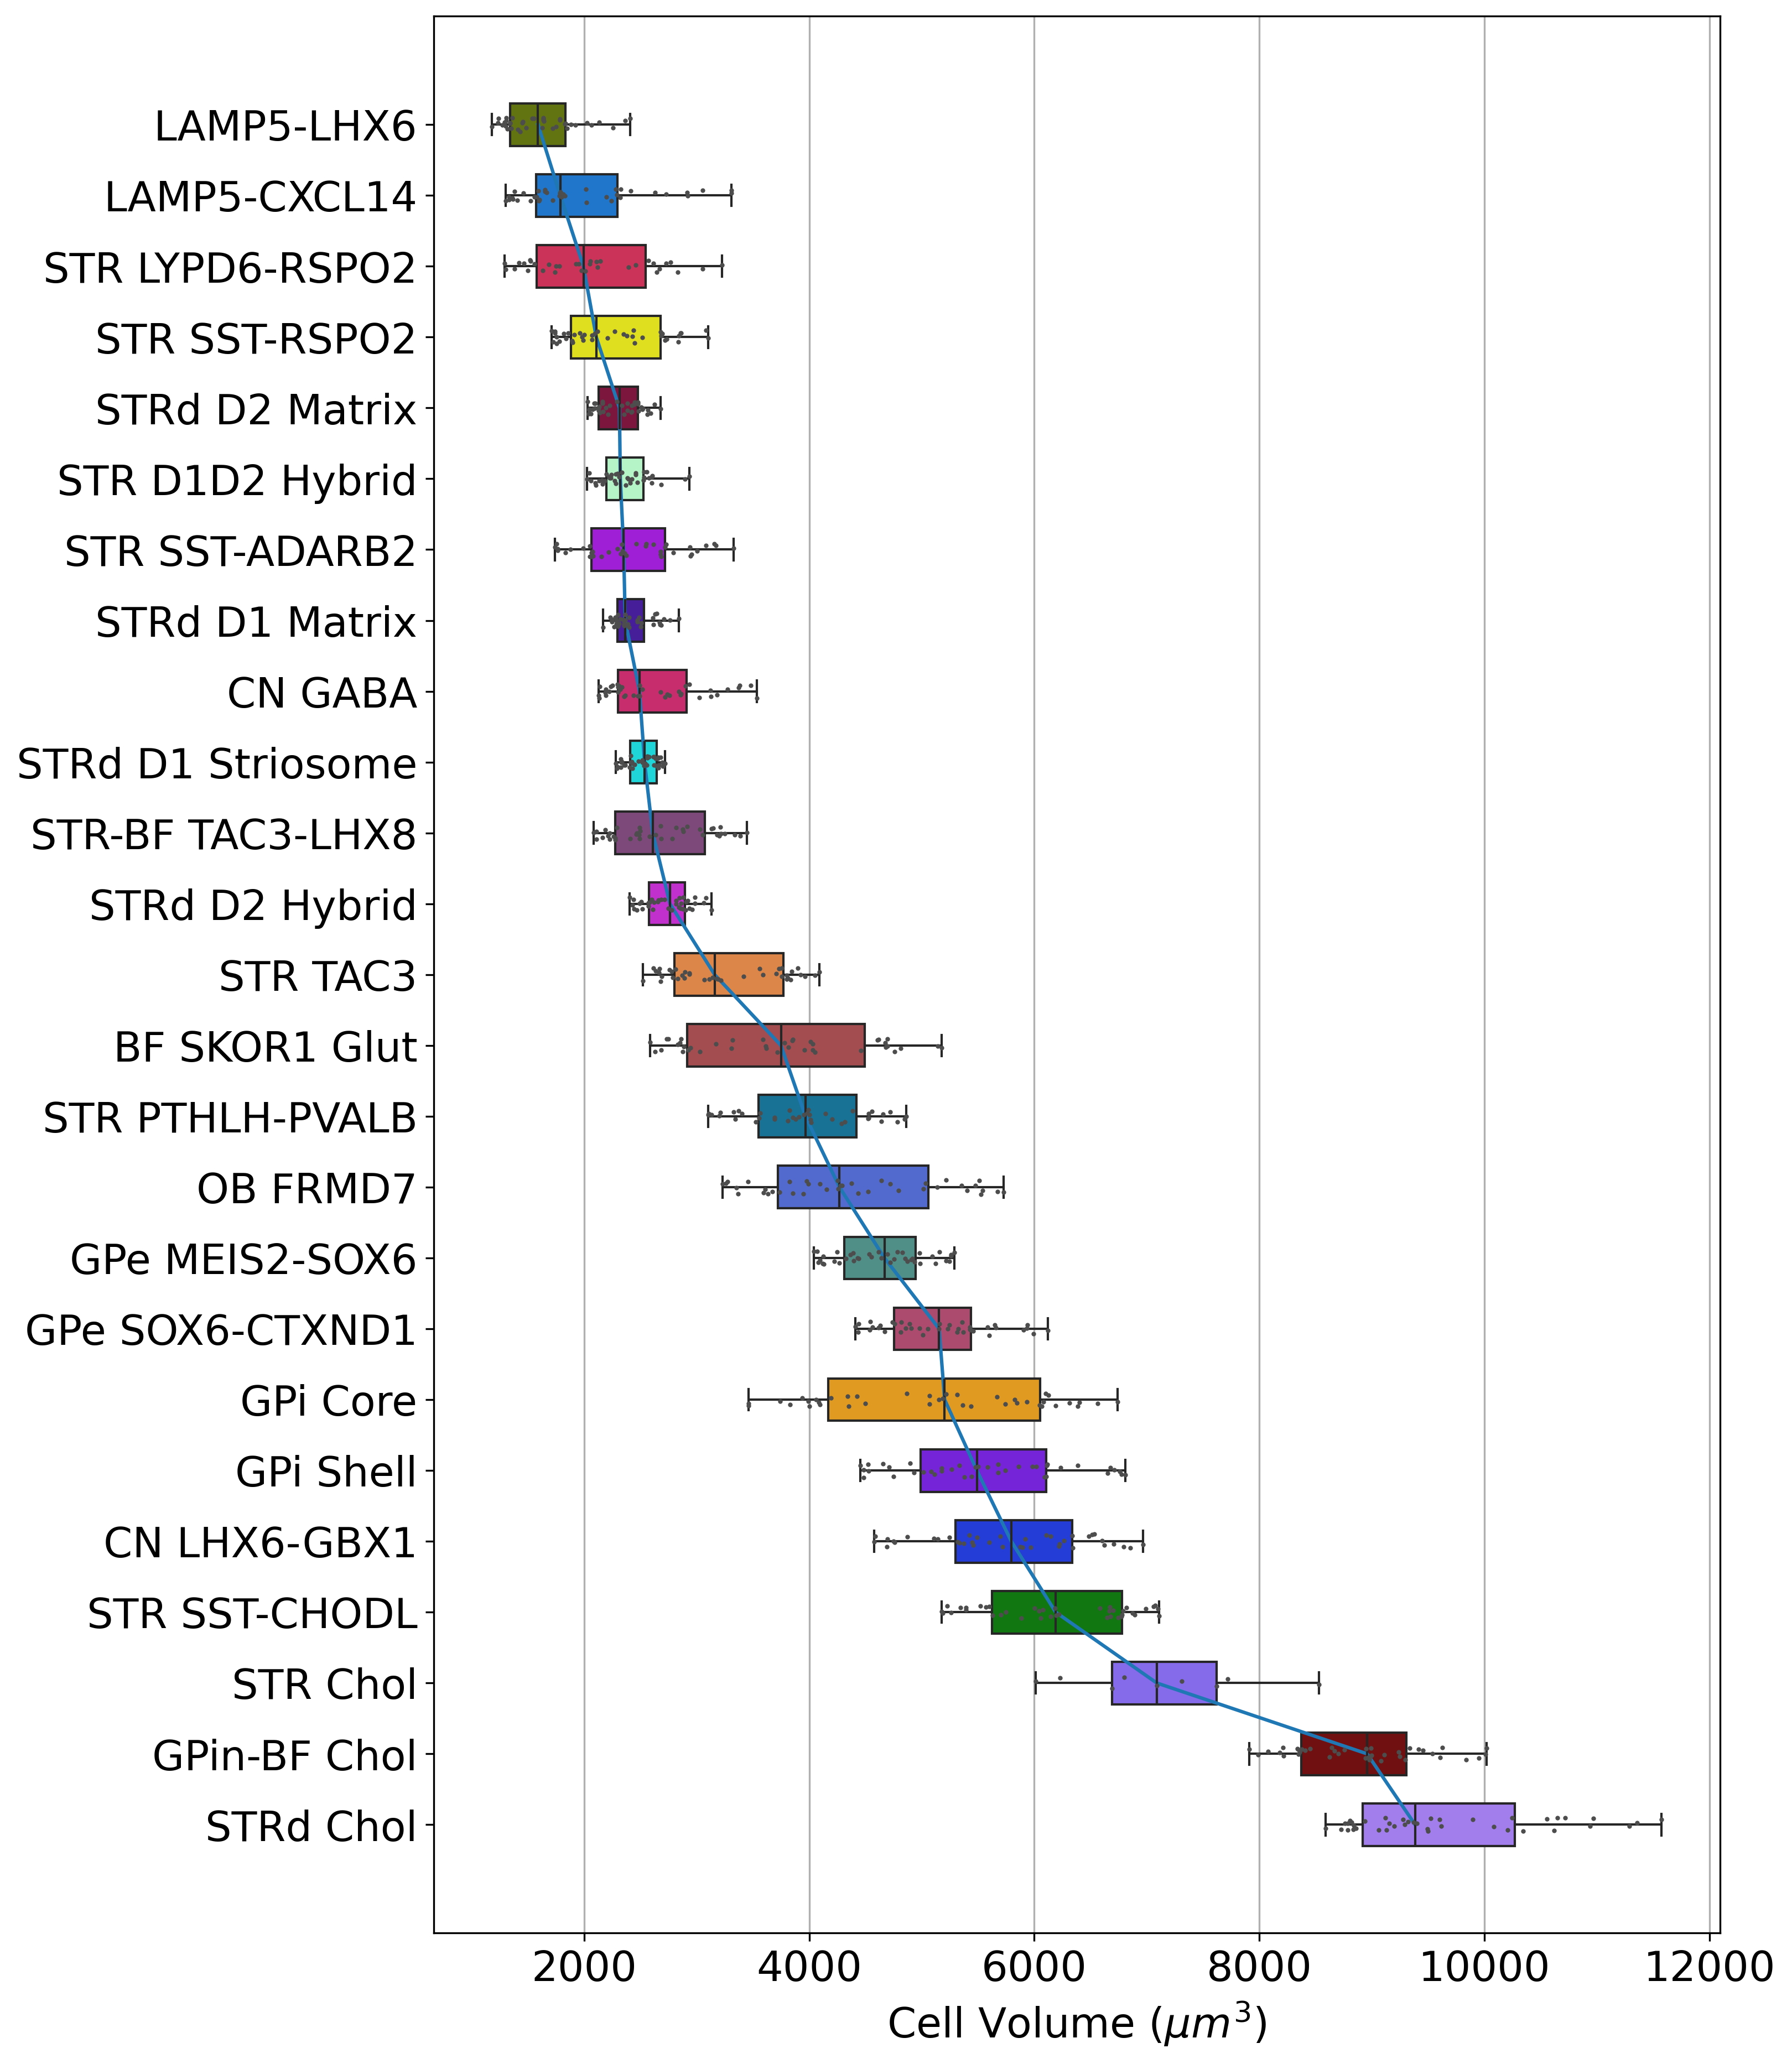

In [ ]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('default')
mpl.rcParams['font.size'] = 18
fig,ax = plt.subplots(1,1, figsize = (10,15), dpi = 300)
# ax.set_xscale("log")
# Plot the orbital period with horizontal boxes
sns.boxplot(
    volm_df_filtered, x="cell_volume", y="celltype_actual_name_short", hue="celltype_actual_name_short",palette=[cluster_map_[type_] for type_ in sorted_celltype],ax = ax,whis=[0, 100], width=.6
)

# Add in points to show each observation
sns.stripplot(volm_df_filtered, x="cell_volume", y="celltype_actual_name_short", size=2, color=".3",ax = ax)

# overlay the line plot of the median volume
ax.plot(sorted_median_volm_val, np.arange(len(sorted_median_volm_val)))
# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
ax.set_xlabel("Cell Volume ($\mu m^3$)")
# sns.despine(trim=True)
plt.savefig(r'./../../figures/transcript_distriubutionFigure/CellVolume_barplot_updated_shortname.png', bbox_inches = 'tight')
plt.savefig(r'./../../figures/transcript_distriubutionFigure/CellVolume_barplot_updated_shortname.tif', bbox_inches = 'tight')
plt.show()

- save the dataframe

In [105]:
volm_df_filtered.to_csv(r'./processed_data/mRNABasedCellVol,_2724p.csv')

#### 3. 3D visualization of spatial distribution of transcripts for selected cell types

- For each cell identify the cell that close to the median and get the file name

In [89]:
med_vl_dict = list(zip(sorted_median_volm_val,sorted_celltype))
med_closeCellId = {}
for val,cellID in med_vl_dict:
    keep = volm_df_filtered['celltype'] == cellID
    med_cellidx = np.argsort(volm_df_filtered[keep].cell_volume - val)[:4]
    med_closeCellId[cellID] = volm_df_filtered[keep]['cellFilename'].values[med_cellidx]

In [90]:
med_closeCellId

{'LAMP5_LHX6_GABA': array(['LAMP5_LHX6_GABA_icell15_info', 'LAMP5_LHX6_GABA_icell60_info',
        'LAMP5_LHX6_GABA_icell20_info', 'LAMP5_LHX6_GABA_icell98_info'],
       dtype=object),
 'LAMP5_CXCL14_GABA': array(['LAMP5_CXCL14_GABA_icell7_info', 'LAMP5_CXCL14_GABA_icell65_info',
        'LAMP5_CXCL14_GABA_icell87_info', 'LAMP5_CXCL14_GABA_icell16_info'],
       dtype=object),
 'STR_LYPD6_RSPO2_GABA': array(['STR_LYPD6_RSPO2_GABA_icell8_info',
        'STR_LYPD6_RSPO2_GABA_icell69_info',
        'STR_LYPD6_RSPO2_GABA_icell40_info',
        'STR_LYPD6_RSPO2_GABA_icell78_info'], dtype=object),
 'STR_SST_RSPO2_GABA': array(['STR_SST_RSPO2_GABA_icell6_info',
        'STR_SST_RSPO2_GABA_icell65_info',
        'STR_SST_RSPO2_GABA_icell71_info',
        'STR_SST_RSPO2_GABA_icell59_info'], dtype=object),
 'STRd_D2_Matrix_MSN': array(['STRd_D2_Matrix_MSN_icell0_info',
        'STRd_D2_Matrix_MSN_icell49_info',
        'STRd_D2_Matrix_MSN_icell93_info',
        'STRd_D2_Matrix_MSN_icell65_info'

- Visualizing the 3D volume of cells using napari

In [1]:
import numpy as np
import napari 
import os

In [ ]:
root_dir = r'./../../Raw_custom_MERFISH_Imaging_data/20250626_hBG_2724_GPie/NeuronImagesV2_BereketCopyNeuronal'
LAMP5_CXCL14_GABA = 'LAMP5_CXCL14_GABA_icell15_info.npz'
STRd_cholinergic_1 = 'STRd_Cholinergic_GABA_icell95_info.npz'
STRd_cholinergic_2 = 'STRd_Cholinergic_GABA_icell21_info.npz'

D1_matrix_MSN = 'STRd_D1_Matrix_MSN_icell79_info.npz' 

D2_matrix_MSN_1 = 'STRd_D2_Matrix_MSN_icell65_info.npz'
D2_matrix_MSN_2 = 'STRd_D2_Matrix_MSN_icell93_info.npz'

D2_StrioMat_MSN = 'STRd_D2_StrioMat_Hybrid_MSN_icell28_info.npz'

Gpi_Core_1 =  'GPi_Core_icell4_info.npz'
Gpi_Core_2 =  'GPi_Core_icell24_info.npz'

Gpi_Shell_1 = 'GPi_Shell_icell1_info.npz'
Gpi_Shell_2 = 'GPi_Shell_icell5_info.npz'

SST_CHODL =  'STR_SST_CHODL_GABA_icell33_info.npz'
SST_ADARB2 =  'STR_SST_ADARB2_GABA_icell15_info.npz'

GPe_MEIS2_SOX6_GABA =  'GPe_MEIS2_SOX6_GABA_icell17_info.npz'

GPe_NDB_SI_LHX6_GBX1_GABA_1 =  'GPe_NDB_SI_LHX6_LHX8_GBX1_GABA_icell10_info.npz'
GPe_NDB_SI_LHX6_GBX1_GABA_2 =  'GPe_NDB_SI_LHX6_LHX8_GBX1_GABA_icell12_info.npz'
GPe_NDB_SI_LHX6_GBX1_GABA_3 =  'GPe_NDB_SI_LHX6_LHX8_GBX1_GABA_icell20_info.npz'


In [ ]:
cellID_list_toImage = [STRd_cholinergic_1,STRd_cholinergic_2,D1_matrix_MSN,D2_matrix_MSN_1,D2_matrix_MSN_2,D2_StrioMat_MSN ,Gpi_Core_1 ,Gpi_Core_2 ,
                       Gpi_Shell_1 ,Gpi_Shell_2 ,SST_CHODL ,SST_ADARB2 ,GPe_MEIS2_SOX6_GABA ,GPe_NDB_SI_LHX6_GBX1_GABA_1 ,
                       GPe_NDB_SI_LHX6_GBX1_GABA_2,GPe_NDB_SI_LHX6_GBX1_GABA_3 ,LAMP5_CXCL14_GABA
]
for celltype_ in cellID_list_toImage:
    fl_ = root_dir + os.sep + celltype_
    vals = np.load(fl_,allow_pickle = True)
    X = vals['X']
    Xneigh = vals['Xneigh']
    Xnuc= vals['Xnuc']
    
    V=napari.Viewer(ndisplay=3)
    V.add_points(X,blending='Additive',face_color='g',size=1.2,edge_width=0,shading='spherical')
    V.add_points(Xneigh,blending='Additive',face_color='r',size=1.2,edge_width=0,shading='spherical')
    V.add_points(Xnuc,blending='Additive',face_color='b',size=1.2,edge_width=0)
    V.scale_bar.visible = True
    V.scale_bar.length = 10
    V.scale_bar.font_size = 12
    V.scale_bar.unit = 'um'
    V.reset_view()
    _ = V.screenshot(r'./../../../tranascriptBasedNeuronprojection_analysis/figures/single_cellTranscript_density_plot' + os.sep + os.path.basename(fl_) + '_dot.png',flash = False)
    V.close()

C:\Users\exx\AppData\Local\Temp\ipykernel_31624\1883780231.py:13: FutureWarning: Argument 'edge_width' is deprecated, please use 'border_width' instead. The argument 'edge_width' was deprecated in 0.5.0 and it will be removed in 0.6.0.
  V.add_points(X,blending='Additive',face_color='g',size=1.2,edge_width=0,shading='spherical')
C:\Users\exx\AppData\Local\Temp\ipykernel_31624\1883780231.py:14: FutureWarning: Argument 'edge_width' is deprecated, please use 'border_width' instead. The argument 'edge_width' was deprecated in 0.5.0 and it will be removed in 0.6.0.
  V.add_points(Xneigh,blending='Additive',face_color='r',size=1.2,edge_width=0,shading='spherical')
C:\Users\exx\AppData\Local\Temp\ipykernel_31624\1883780231.py:15: FutureWarning: Argument 'edge_width' is deprecated, please use 'border_width' instead. The argument 'edge_width' was deprecated in 0.5.0 and it will be removed in 0.6.0.
  V.add_points(Xnuc,blending='Additive',face_color='b',size=1.2,edge_width=0)
C:\Users\exx\AppDat

#### 4. Statistical test between the volumes of SST-CHODL and SST/ADARB2

In [1]:
import numpy as np
import pandas as pd
import scipy 

In [6]:
volm_df_filtered = pd.read_csv('./processed_data/mRNABasedCellVol_2724p.csv', index_col = 0)
volm_df_filtered

,cell_volume,celltype,cellFilename,celltype_actual_name,celltype_actual_name_short
2426,1722.482118,LAMP5_LHX6_GABA,LAMP5_LHX6_GABA_icell57_info,LAMP5-LHX6 GABA,LAMP5-LHX6
2431,1239.564972,LAMP5_LHX6_GABA,LAMP5_LHX6_GABA_icell20_info,LAMP5-LHX6 GABA,LAMP5-LHX6
2436,1782.831257,LAMP5_LHX6_GABA,LAMP5_LHX6_GABA_icell81_info,LAMP5-LHX6 GABA,LAMP5-LHX6
2437,1309.168283,LAMP5_LHX6_GABA,LAMP5_LHX6_GABA_icell68_info,LAMP5-LHX6 GABA,LAMP5-LHX6
2438,1351.243488,LAMP5_LHX6_GABA,LAMP5_LHX6_GABA_icell67_info,LAMP5-LHX6 GABA,LAMP5-LHX6
...,...,...,...,...,...
932,8833.632235,STRd_Cholinergic_GABA,STRd_Cholinergic_GABA_icell12_info,STRd Cholinergic GABA,STRd Chol
934,9524.667140,STRd_Cholinergic_GABA,STRd_Cholinergic_GABA_icell55_info,STRd Cholinergic GABA,STRd Chol
935,9131.904039,STRd_Cholinergic_GABA,STRd_Cholinergic_GABA_icell2_info,STRd Cholinergic GABA,STRd Chol
950,8588.921280,STRd_Cholinergic_GABA,STRd_Cholinergic_GABA_icell62_info,STRd Cholinergic GABA,STRd Chol


In [7]:
np.unique(volm_df_filtered['celltype_actual_name'])

array(['AMY-SLEA-BNST GABA', 'BF SKOR1 Glut', 'GPe MEIS2-SOX6 GABA',
       'GPe SOX6-CTXND1 GABA', 'GPe-NDB-SI LHX6-LHX8-GBX1 GABA',
       'GPi Core', 'GPi Shell', 'GPin-BF Cholinergic GABA',
       'LAMP5-CXCL14 GABA', 'LAMP5-LHX6 GABA', 'OB FRMD7 GABA',
       'STR Cholinergic GABA', 'STR D1D2 Hybrid MSN',
       'STR FS PTHLH-PVALB GABA', 'STR LYPD6-RSPO2 GABA',
       'STR SST-ADARB2 GABA', 'STR SST-CHODL GABA', 'STR SST-RSPO2 GABA',
       'STR TAC3-PLPP4 GABA', 'STR-BF TAC3-PLPP4-LHX8 GABA',
       'STRd Cholinergic GABA', 'STRd D1 Matrix MSN',
       'STRd D1 Striosome MSN', 'STRd D2 Matrix MSN',
       'STRd D2 StrioMat Hybrid MSN'], dtype=object)

In [11]:
sst_chodl_volume = volm_df_filtered[volm_df_filtered['celltype_actual_name'] == 'STR SST-CHODL GABA']['cell_volume'].values
sst_adarb2_volume = volm_df_filtered[volm_df_filtered['celltype_actual_name'] == 'STR SST-ADARB2 GABA']['cell_volume'].values

In [15]:
ranksum_res = scipy.stats.ranksums(sst_chodl_volume,sst_adarb2_volume, alternative='greater' )
ranksum_res

RanksumsResult(statistic=7.69800358919501, pvalue=6.910424523801817e-15)